In [2]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from collections import deque
from IPython.display import HTML

In [12]:
from __future__ import annotations
import copy

import math
import random

from matplotlib import pyplot as plt
import bin_repr as bi
import numpy as np

a = -10
b = 10
epsilon = 6.1038e-4
N = round((b - a) / epsilon) + 1
bits = math.floor(math.log2(N)) + 1  # = ceil

func = lambda x: np.sin(x) - 0.2 * abs(x)


class Individual:
    def __init__(self, value: float) -> None:
        self.value = value
        self.fitness = func(value)

    @classmethod
    def new(cls, genotype: list[int]):
        value = bi.bin2dec(bi.gray2bin(genotype))
        return cls(bi.inverse_map(value, a, epsilon))

    def getGenotype(self):
        shift = bi.my_map(self.value, a, b, epsilon)
        return bi.bin2gray(bi.dec2bin(shift, bits))


def crossover(p1: Individual, p2: Individual) -> list[Individual]:
    # one-point crossover
    point = random.randint(1, bits - 2)
    c1, c2 = copy.deepcopy(p1.getGenotype()), copy.deepcopy(p2.getGenotype())
    c1[point:], c2[point:] = c2[point:], c1[point:]

    return Individual.new(c1), Individual.new(c2)


def mutate(ind: Individual):
    # one flip mutation, GLOBAL
    mut = copy.deepcopy(ind.getGenotype())
    # point = random.randint(0, bits - 1)
    # g1 = mut[point]
    # mut[point] = (g1 + 1) % 2

    # flipping mutation, GLOBAL RUIDOSO
    # p = 0.5
    # for i in range(len(mut)):
    #     if random.random() < p:
    #         mut[i] = (mut[i] + 1) % 2

    # swap mutation, LOCAL
    i, j = random.sample(range(len(mut)), k=2)
    mut[i], mut[j] = mut[j], mut[i]
    return Individual.new(mut)


def select(population: list[Individual]):
    tournament_size = 3
    new_offspring = []
    for _ in range(len(population)):
        candidates = [random.choice(population) for _ in range(tournament_size)]
        new_offspring.append(max(candidates, key=lambda ind: ind.fitness))
    return new_offspring


def create_random():
    return Individual(random.random() * (b - a) + a)


def get_best(population: list[Individual]) -> Individual:
    best = population[0]
    for ind in population:
        if ind.fitness > best.fitness:
            best = ind
    return best


def plot_population(population: list[Individual], generation_number: int):
    best = get_best(population)
    x = np.linspace(-10, 10)

    plt.plot(x, func(x), '--', color="blue")
    plt.plot([ind.value for ind in population],
             [ind.fitness for ind in population], 'o', color='orange')
    plt.plot(best.value, best.fitness, 's', color="green")
    plt.title(f"Generation number {generation_number}")
    plt.show()
    plt.close()


# GA CANONICAL FLOW
random.seed(52)
# random.seed(16) # local maximum
POPULATION_SIZE = 10
CROSSOVER_PROBABILITY = 0.8
MUTATION_PROBABILITY = 0.5
MAX_GENERATION = 15


first_population: list[Individual] = [create_random() for _ in range(POPULATION_SIZE)]

generation_number = 0

population = first_population.copy()
data = []
while generation_number < MAX_GENERATION:
    generation_number += 1

    # SELECTION
    offspring = select(population)

    # CROSSOVER
    crossed_offspring: list[Individual] = []
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CROSSOVER_PROBABILITY:
            kid1, kid2 = crossover(ind1, ind2)
            crossed_offspring.append(kid1)
            crossed_offspring.append(kid2)
        else:
            crossed_offspring.append(ind1)
            crossed_offspring.append(ind2)

    # MUTATION
    mutated_offspring: list[Individual] = []
    # we mutate each offspring
    for mutant in crossed_offspring:
        if random.random() < MUTATION_PROBABILITY:
            new_mutant = mutate(mutant)
            mutated_offspring.append(new_mutant)
        else:
            mutated_offspring.append(mutant)

    population = mutated_offspring.copy()
    data.append(population)


In [35]:
def get_info(ind: Individual):
    return [ind.fitness, ind.fitness]

In [ ]:
for i in range(generation_number)

In [36]:
data = np.array(data)
num_generation = 1
individual = 5
get_info(data[num_generation][individual])

[-1.322150655230427, -1.322150655230427]

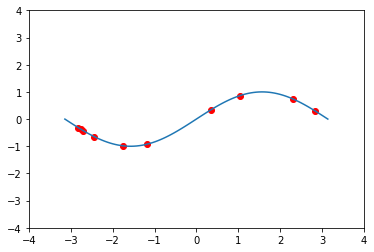

In [4]:
import random
POINTS = 100
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

x = np.linspace(-np.pi, np.pi, POINTS)
y = np.sin(x)
ax.plot(x, y)


def init():
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    return ln,


def animate(frame):
    index_sample = random.sample(range(POINTS), k=10)
    x_sample = x[index_sample]
    y_sample = y[index_sample]
    ln.set_data(x_sample, y_sample)
    return ln,


ani = FuncAnimation(fig, animate, frames=POINTS, interval=100, init_func=init, blit=True)
HTML(ani.to_jshtml())


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
HTML(ani.to_jshtml())

NameError: name 'fig' is not defined